In [71]:
from torch.nn.attention.flex_attention import create_mask

from diveslowlearnfast import create_heatmaps
%load_ext autoreload
%autoreload 2

import torch
import matplotlib

import numpy as np
import diveslowlearnfast as dlf
import matplotlib.pyplot as plt
import tools.visualise as viz

from diveslowlearnfast.config import Config, load_config
from diveslowlearnfast.train import StatsDB
from diveslowlearnfast.models import SlowFast
from diveslowlearnfast.datasets import Diving48Dataset, Diving48ConfounderDatasetWrapper
from diveslowlearnfast.visualise.gradcam import GradCAM
from torch.utils.data import DataLoader
from diveslowlearnfast.egl import ExplainerStrategy
from PIL import Image


from diveslowlearnfast.train.stats import get_value, get_tuple, get_column, get_dict, get_df


matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
chk = torch.load('best.pth', map_location='cpu', weights_only=False)
chk['epoch']

190

In [10]:
cfg = load_config('config.json')
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.DATA.TEST_CROP_SIZE = 224
cfg.TRAIN.BATCH_SIZE = 1
cfg.DATA_LOADER.NUM_WORKERS = 1
cfg.DATA_LOADER.PIN_MEMORY = False
cfg.DATA_LOADER.USE_DECORD = False
model = dlf.model_from_checkpoint(cfg, 'checkpoint.pth')
gc = GradCAM(model,
             target_layers=['s5/pathway0_res2', 's5/pathway0_res2'],
             data_mean=cfg.DATA.MEAN,
             data_std=cfg.DATA.STD,
             colormap='jet')
model.eval()

SlowFast(
  (s1): VideoModelStem(
    (pathway0_stem): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (pathway1_stem): ResNetBasicStem(
      (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
      (bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
  )
  (s1_fuse): FuseFastToSlow(
    (conv_f2s): Conv3d(8, 16, kernel_size=(7, 1, 1), stride=(4, 1, 1), padding=(3, 0, 0), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [11]:
stats = StatsDB('stats.db')
run_id = stats.execute_query('SELECT DISTINCT(run_id) FROM stats', extractor=get_value)

run_id

'/home/s2871513/Projects/diveslowlearnfast/results/run33'

In [12]:
include_labels = stats.execute_query('SELECT DISTINCT(gt) FROM stats WHERE split = "train"', extractor=get_tuple)
include_labels

(45, 18, 25)

In [13]:
diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=dlf.get_test_transform(cfg),  # use test_transform instead
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
    include_labels=include_labels,
)

confounder_diving48 = Diving48ConfounderDatasetWrapper(
    diving48,
    cfg
)

loader = DataLoader(
    diving48,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

confounder_loader = DataLoader(
    confounder_diving48,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

In [46]:
xb, yb, _, _, vidname, *_ = next(iter(confounder_loader))

In [48]:
x = xb.squeeze(0)
y = yb.squeeze(0)

x.shape, y, diving48.get_label(y.item()), vidname

(torch.Size([3, 8, 224, 224]),
 tensor(45),
 ['Reverse', '35som', 'NoTwis', 'TUCK'],
 ('vlfy4cny75s_00161',))

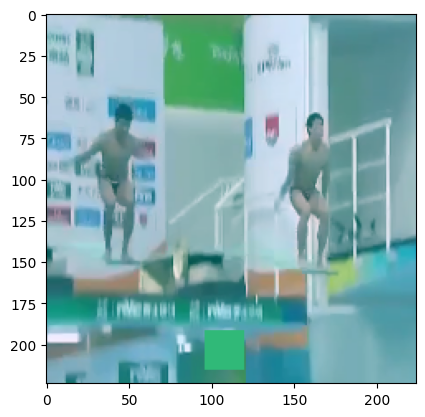

In [57]:
x_denorm = dlf.tensor_denorm(x, cfg.DATA.MEAN, cfg.DATA.STD)
x_denorm = np.uint8(dlf.tensor_min_max_norm(x_denorm) * 255)

plt.imshow(x_denorm[4])

In [59]:
 Image.fromarray(x_denorm[4]).save(f'{vidname}_confounder.png')

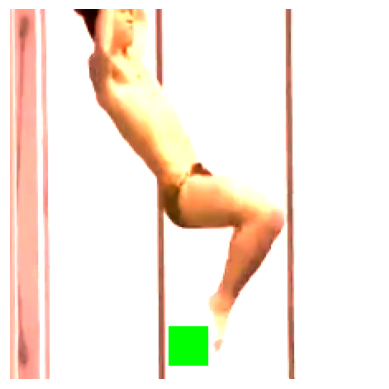

In [34]:
dlf.frameshow(x, frame_idx=1)

In [50]:
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA)
probs = model(inputs)
torch.topk(probs, 5).indices.numpy()

array([[45, 18, 25, 11, 13]])

In [51]:
print(f'model prediction: {probs.argmax(dim=1).item()}')
print(f'actual : {y.item()}')

model prediction: 45
actual : 45


In [52]:
localisation_maps, logits = gc(inputs)

In [53]:
heatmaps = dlf.create_heatmaps(inputs,
                               localisation_maps,
                               cfg.DATA.MEAN,
                               cfg.DATA.STD,
                               colormap='jet')
slow_map = heatmaps[0][0]
fast_map = heatmaps[1][0]

slow_map.shape, fast_map.shape

(torch.Size([3, 2, 224, 224]), torch.Size([3, 8, 224, 224]))

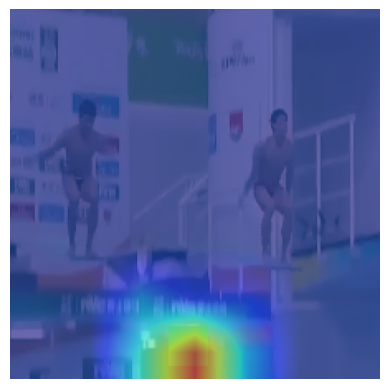

In [54]:
dlf.frameshow(slow_map, frame_idx=1)

In [65]:
image = np.uint8(slow_map.permute(1, 2, 3, 0)[1] * 255)
Image.fromarray(image).save(f'{vidname}_confounder_gradcam.png')

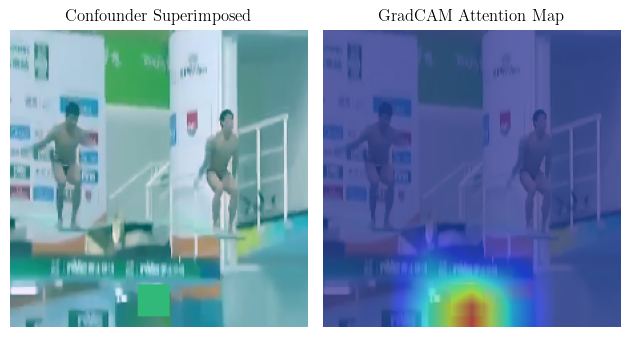

In [74]:
left = x_denorm[4]
right = image

ax = plt.subplot(121)
ax.imshow(left)
ax.axis('off')
ax.set_title('Confounder Superimposed')

ax = plt.subplot(122)
ax.imshow(right)
ax.axis('off')
ax.set_title('GradCAM Attention Map')

plt.tight_layout()
plt.savefig(f'{vidname}_confounder_gradcam.png')
plt.show()

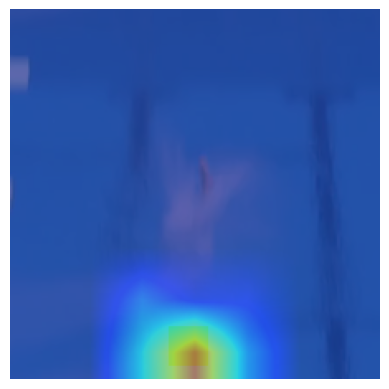

In [24]:
dlf.frameshow(fast_map, frame_idx=5)

In [25]:

def create_gif(frames, save_path):
    if type(frames) == torch.Tensor:
        frames = frames.permute(1, 2, 3, 0).detach().cpu().numpy()
        frames = np.uint8(frames * 255)

    images = [Image.fromarray(frame) for frame in frames]
    images[0].save(save_path, save_all=True, append_images=images[1:], duration=240, loop=0)



In [26]:
save_path = f"{'_'.join(diving48.get_label(y.item()))}_fast_confounder_heatmap.gif"
save_path

'Reverse_35som_NoTwis_TUCK_fast_confounder_heatmap.gif'

In [27]:
fast_map.shape

torch.Size([3, 8, 224, 224])

In [28]:
# create_gif(fast_map, save_path)

In [29]:
save_path = f"{'_'.join(diving48.get_label(y.item()))}.gif"
save_path

'Reverse_35som_NoTwis_TUCK.gif'

In [30]:
x_denorm = dlf.tensor_denorm(x, cfg.DATA.MEAN, cfg.DATA.STD)
x_denorm = np.uint8(dlf.tensor_min_max_norm(x_denorm) * 255)
# create_gif(x_denorm, save_path)

In [31]:
xb, yb = dlf.get_sample(loader)

In [32]:
x = xb.squeeze(0)
y = yb.squeeze(0)

x.shape, y, diving48.get_label(y.item())

(torch.Size([3, 8, 224, 224]),
 tensor(25),
 ['Forward', '25som', 'NoTwis', 'TUCK'])

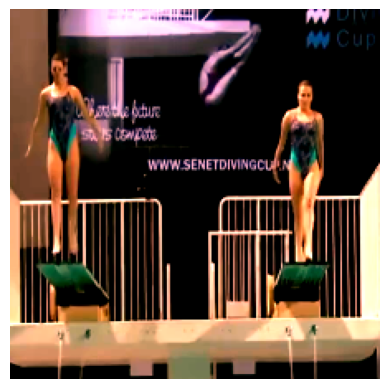

In [33]:
dlf.frameshow(x)

In [34]:
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA)
probs = model(inputs)
torch.topk(probs, 5).indices.numpy()

array([[25, 45, 18, 27, 34]])

In [35]:
print(f'model prediction: {probs.argmax(dim=1).item()}')
print(f'actual : {y.item()}')

model prediction: 25
actual : 25


In [36]:
localisation_maps, _ = gc(inputs)
heatmaps = dlf.create_heatmaps(inputs,
                               localisation_maps,
                               cfg.DATA.MEAN,
                               cfg.DATA.STD,
                               colormap='jet')
slow_map = heatmaps[0][0]
fast_map = heatmaps[1][0]

slow_map.shape, fast_map.shape

(torch.Size([3, 2, 224, 224]), torch.Size([3, 8, 224, 224]))

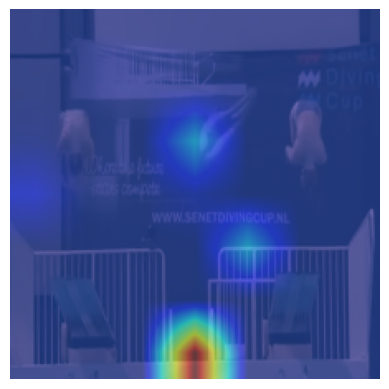

In [37]:



dlf.frameshow(slow_map, frame_idx=1)

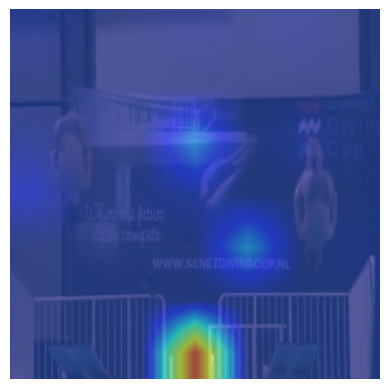

In [38]:
dlf.frameshow(fast_map, frame_idx=5)

In [39]:
save_path = f"{'_'.join(diving48.get_label(y.item()))}_fast_heatmap.gif"
save_path

'Forward_25som_NoTwis_TUCK_fast_heatmap.gif'

In [40]:
create_gif(fast_map, save_path)

In [86]:
cfg.EGL.METHOD = 'gradcam'
explainer = ExplainerStrategy.get_explainer(model, cfg, device=torch.device('cpu'))
explainer

GradCamExplainer()

In [87]:
localisation_maps, _ = explainer(inputs, yb)

slow_map = localisation_maps[0][0]
fast_map = localisation_maps[1][0]

slow_map.shape, fast_map.shape

(torch.Size([1, 2, 224, 224]), torch.Size([1, 8, 224, 224]))

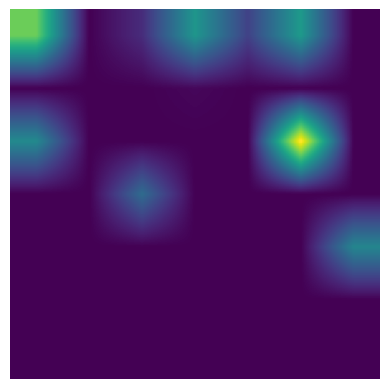

In [88]:
dlf.frameshow(slow_map, frame_idx=0)

In [91]:
from diveslowlearnfast.egl.generate_masks import _generate_masks

slow_mask = _generate_masks(slow_map.unsqueeze(0), invert=False, percentile=20)
fast_mask = _generate_masks(fast_map.unsqueeze(0), invert=cfg.EGL.INVERT_MASKS, percentile=20)

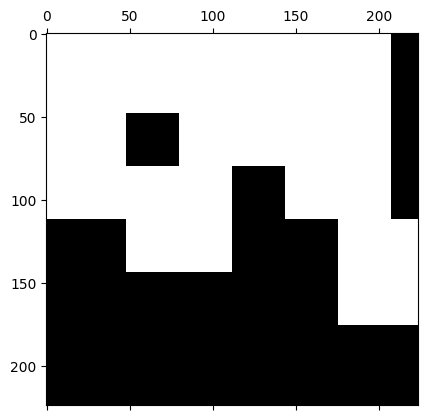

In [93]:
plt.matshow(np.uint8(slow_mask.transpose(0, 2, 3, 4, 1)[0][0]), cmap='gray')

In [117]:
cfg.EGL.METHOD = 'confounder'
explainer = ExplainerStrategy.get_explainer(model, cfg, device=torch.device('cpu'))
explainer

<function diveslowlearnfast.egl.explainer.ExplainerStrategy.get_explainer.<locals>._confounder_explainer(inputs, y)>

In [127]:
localisation_maps, _ = explainer(inputs, yb)

slow_map = localisation_maps[0]
fast_map = localisation_maps[1]

slow_map.shape, fast_map.shape

(torch.Size([1, 1, 2, 224, 224]), torch.Size([1, 1, 8, 224, 224]))

In [128]:
slow_mask = _generate_masks(slow_map, invert=False, percentile=95)

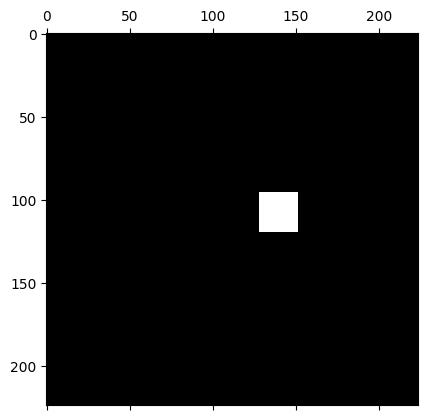

In [129]:
plt.matshow(np.uint8(slow_mask.transpose(0, 2, 3, 4, 1)[0][0]), cmap='gray')